# Super Scooters vs Taxis

In this project, we simulate a real-world policy intervention to evaluate and compare several causal inference techniques. While inspired by open regional data from Statistics Sweden (SCB), we deliberately generated synthetic data to control the underlying structure and embed a known treatment effect. This approach allows us to rigorously benchmark causal methods in a controlled, yet realistic setting.

We assume that in Region 8, starting in 2018, a highly convenient electric scooter service was introduced. As a result, the number of taxi owners in this region dropped by 25% — a known, manually introduced effect.

The goal is to test how well different causal inference methods can detect and estimate this artificial intervention using observational-style panel data.

The dataset structure mirrors real-world regional statistics and includes:

- region: region code
- year
- taxis: number of taxi owners
- users_with_cars: number of private car owners
- avg_disposable_income_in_pba: average disposable income measured in price base amounts
- prisbasbelopp: price base amount
- avg_disposable_income_sek: average disposable income in SEK per region and year
- tax_rate: average tax rate per region and year (%)
- taxi_per_1000: taxi owners per 1000 residents
- treatment: a binary flag for the treated unit (Region 8 from 2018)
- taxis_adj: adjusted number of taxi owners (reflecting the −25% simulated treatment effect)


We apply and compare the following causal inference approaches:

- Difference-in-Differences (DiD): Leverages before–after differences between treated and control groups.

- Synthetic Control Method (SCM): Builds a synthetic counterfactual from a weighted combination of untreated regions.

- Bayesian Structural Time Series (BSTS): Constructs a probabilistic forecast of the counterfactual, incorporating trend, noise, and uncertainty.

Our objective is to evaluate how well each method recovers the known, simulated treatment effect, and to compare their robustness, interpretability, and real-world applicability.

# lib

In [270]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette(sns.color_palette("Paired")))

from causalml.match import create_table_one

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.formula.api as smf

from scipy.optimize import fmin_slsqp


from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.dataset import load_iclaims
from orbit.utils.plot import get_orbit_style

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Generate Data 

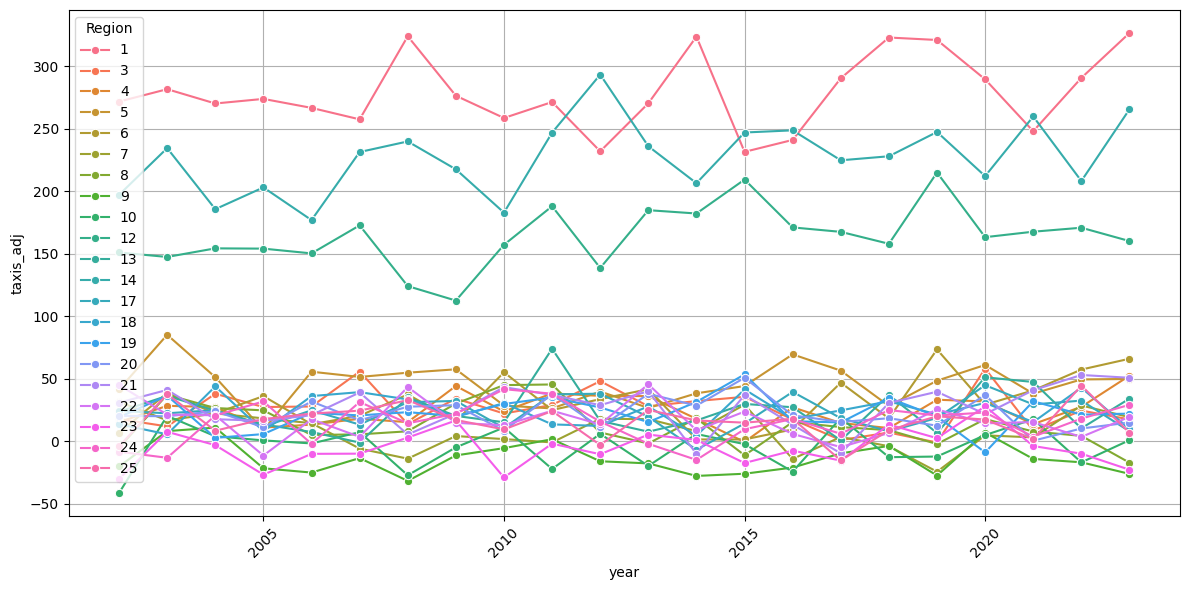

In [211]:
np.random.seed(42)

df_pop_grouped=pd.read_csv('population_final.csv')
del df_pop_grouped['Unnamed: 0']
df_pop_grouped['region']=df_pop_grouped['region'].astype(str)

region_pop = df_pop_grouped.groupby('region')['population'].mean()


region_scale = region_pop / region_pop.max() * 3.0



n_regions = 25
years = list(range(2002, 2024))
treated_region = '8'
treatment_start = 2018


df = pd.DataFrame([(str(r), y) for r in range(1, n_regions + 1) for y in years],
                  columns=['region', 'year'])


df = df.merge(region_scale.rename('region_scale'), on='region', how='left')

df = df.merge(df_pop_grouped, on=['region','year'])


df['users_with_cars'] = df['region_scale'] * np.random.normal(200_000, 30_000, size=len(df))
df['avg_disposable_income_in_pba'] = df['region_scale'] * np.random.normal(3.5, 0.2, size=len(df))
df['tax_rate'] = np.random.normal(30, 1, size=len(df))  


df['years_since_start'] = df['year'] - df['year'].min()

df['users_with_cars'] *= 1 + 0.01 * df['years_since_start']
df['avg_disposable_income_in_pba'] *= 1 + 0.008 * df['years_since_start'] 


def generate_taxis(row):
    base = (
        50 +
        0.0002 * row['users_with_cars'] +
        15 * row['avg_disposable_income_in_pba'] -
        2.5 * row['tax_rate']
    )
    noise = np.random.normal(0, 15)
    return base + noise

df['taxis'] = df.apply(generate_taxis, axis=1)


df['treatment'] = ((df['region'] == '8') & (df['year'] >= 2018)).astype(int)
df['taxis_adj'] = df.apply(
    lambda row: row['taxis'] * 0.75 if row['treatment'] == 1 else row['taxis'],
    axis=1
)

df['date'] = pd.to_datetime(df['year'].astype(str) + "-01-01")


plt.figure(figsize=(12, 6))
sns.lineplot(data=df , x="year", y="taxis_adj", hue="region", marker="o")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend(title="Region")
plt.show()


In [212]:
mean_post = df[(df['region'] == '8') & (df['year'] >= 2018)]['taxis_adj'].mean()
mean_pre = df[(df['region'] == '8') & (df['year'] < 2018)]['taxis_adj'].mean()
print(f" ATT: {mean_post / mean_pre:.2%}")

 ATT: 19.13%


We set -25%, but due to the noise and the "imperfection" of the data, the average after 2018 was 19% less.

Let’s make sure our treatment and control groups are actually comparable before jumping to conclusions. We’ll use Table One to check if they’re balanced across key characteristics—like income, population, or number of taxis. If there are big differences before treatment, it’s risky to attribute post-treatment effects to the intervention itself. Balance first, inference later.

In [213]:
create_table_one(df, 'treatment', ['tax_rate',
                                'avg_disposable_income_in_pba', 
                                'users_with_cars', 'population', 'taxis_adj'])

#SMD —  Standardized Mean Difference

,Control,Treatment,SMD
Variable,,,
n,456,6,
avg_disposable_income_in_pba,2.67 (2.85),1.62 (0.11),-0.5237
population,464181.45 (528645.75),246279.83 (1127.75),-0.5829
tax_rate,30.06 (1.01),29.55 (0.93),-0.5199
taxis_adj,47.33 (77.65),3.10 (11.90),-0.7962
users_with_cars,155661.04 (168248.88),95436.85 (5337.66),-0.506


Baseline covariate balance check reveals notable differences between treated and control regions. SMD exceed 0.5 across multiple covariates, including income (SMD = -0.52), population (-0.58), tax rate (-0.52), taxi ownership (-0.80), and car ownership (-0.51). These imbalances indicate that untreated regions are structurally different from the treated unit, potentially biasing causal estimates if used without adjustment. Matching or other balancing techniques are necessary before applying causal inference methods.

It's just that DiD with such groups can give a biased estimate.

# Nearest Neighbor Matching (NNM) or Covariate Matching 

A distance-based algorithm  selects control regions that closely resemble the treated region based on key covariates before the intervention. This helps reduce bias when estimating treatment effects and provides a more credible counterfactual - what would have happened in the absence of treatment. An output is s set of matched control regions to serve as donors in causal inference methods like Difference-in-Differences (DiD), Synthetic Control, etc.


In [214]:
pre_df = df[(df['year']<2018)&(df['year']>=2010)].copy()

covariates = [
              'avg_disposable_income_in_pba',
              'taxis',
              'tax_rate', 
              'users_with_cars',
              'population'
              ]

In [215]:
pre_avg = pre_df[(pre_df['year'] >= 2010) & (pre_df['year'] < 2018)] \
             .groupby('region')[covariates].mean().reset_index()

X = pre_avg[pre_avg['region'] != '8'][covariates]
X_treated = pre_avg[pre_avg['region'] == '8'][covariates]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_treated_scaled = scaler.transform(X_treated)

nn = NearestNeighbors(n_neighbors=3)  
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_treated_scaled)

nnm_regions = pre_avg[pre_avg['region'] != '8']['region'].values[indices[0]]
print("Matched control regions by NNM:", nnm_regions)

Matched control regions by NNM: ['20' '25' '4']


In [216]:
nnm_regions_total=np.append(nnm_regions, '8')
nnm_regions_total

array(['20', '25', '4', '8'], dtype=object)

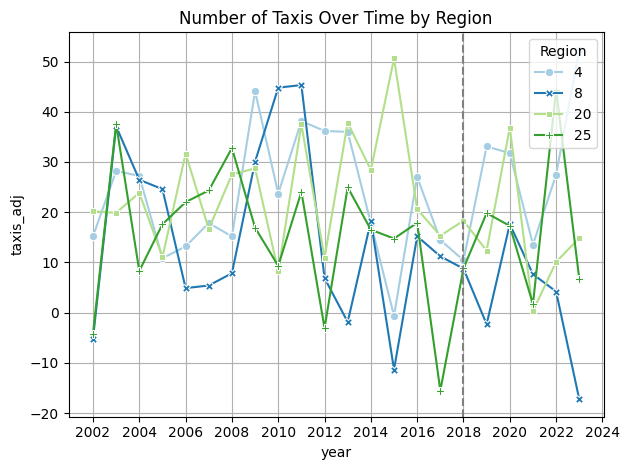

In [217]:
sns.lineplot(
    data=df[df['region'].isin(nnm_regions_total)], 
    x="year", 
    y="taxis_adj", 
    hue="region", 
    style="region",        
    markers=True,        
    dashes=False,       
    palette="Paired"     
)

plt.grid(True)
plt.legend(title="Region")
plt.title("Number of Taxis Over Time by Region")
plt.xticks(ticks=range(2002, 2026, 2))
plt.axvline(2018, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [218]:
df_subset = pre_df[pre_df['region'].isin(nnm_regions_total)]

df_subset['treatment_region'] = (df_subset['region'] == '8').astype(int)

/var/folders/b5/c5pvdv8n0lx6dbv9jfk7n24r0000gn/T/ipykernel_885/519757352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['treatment_region'] = (df_subset['region'] == '8').astype(int)


In [219]:
table_one = create_table_one(
    data=df_subset,
    treatment_col='treatment_region',
    features=[
        'tax_rate',
        'avg_disposable_income_in_pba', 
        'users_with_cars', 
        'population', 
        'taxis_adj'
    ]
)

table_one

,Control,Treatment,SMD
Variable,,,
n,24,8,
avg_disposable_income_in_pba,1.69 (0.09),1.53 (0.11),-1.611
population,269765.17 (15278.58),236645.25 (4161.31),-2.9579
tax_rate,29.76 (1.09),29.84 (0.82),0.0798
taxis_adj,20.45 (15.09),16.05 (20.24),-0.2467
users_with_cars,97137.44 (10958.11),85286.58 (13405.61),-0.968


Despite an attempt to improve the balance by selecting subsets, the SMD shows a serious imbalance in almost all covariates except tax_rate. But the taxis_adj is almost normal.


Let's try another method - prospensity score. 

A propensity score is the probability that a unit (e.g., a region) receives the treatment, given a set of observed covariates. It's typically estimated using a logistic regression model.

Propensity scores are used to create a comparable control group by matching treated and untreated units with similar scores — i.e., similar likelihoods of being treated based on observed characteristics. Meanwhile, Prosperity Score matches on a single value — the propensity score, NNM - on multiple features directly. 

Purpose: 
- PS: 	Balances observed covariates between groups
- NNM: Finds most similar raw feature vectors





## Prosperity Score 

In [220]:
pre_df['treatment_region'] = (pre_df['region'] == '8').astype(int)

df_psm = pre_df.groupby(['region', 'treatment_region'])[covariates].mean().reset_index()

In [221]:
X = df_psm[covariates]
y = df_psm['treatment_region']

ps_model = LogisticRegression()
df_psm['propensity_score'] = ps_model.fit(X, y).predict_proba(X)[:, 1]

/Users/nadia/Documents/my_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [222]:
treated_ps = df_psm[df_psm['treatment_region'] == 1]
control_ps = df_psm[df_psm['treatment_region'] == 0]

control_ps['score_diff'] = abs(control_ps['propensity_score'] - treated_ps['propensity_score'].values[0])

matched_regions_ps = control_ps.sort_values('score_diff').head(3)['region'].values

print("Matched control regions via PS:", matched_regions_ps)

Matched control regions via PS: ['7' '4' '22']


/var/folders/b5/c5pvdv8n0lx6dbv9jfk7n24r0000gn/T/ipykernel_885/3298501000.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_ps['score_diff'] = abs(control_ps['propensity_score'] - treated_ps['propensity_score'].values[0])


In [223]:
ps_regions_total=np.append(matched_regions_ps, '8')
ps_regions_total

array(['7', '4', '22', '8'], dtype=object)

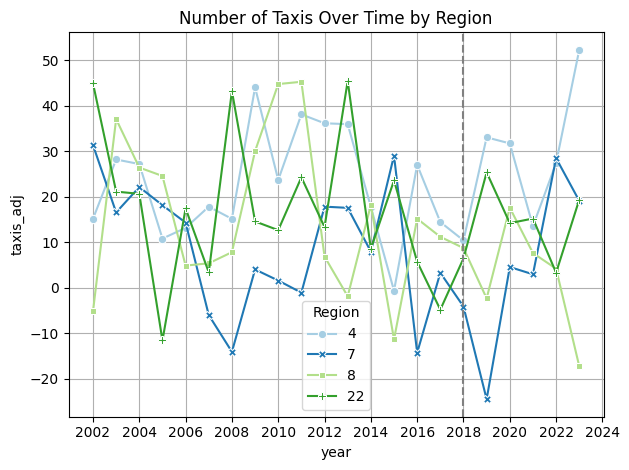

In [224]:
sns.lineplot(
    data=df[df['region'].isin(ps_regions_total)],
    x="year", 
    y="taxis_adj", 
    hue="region", 
    style="region",        
    markers=True,        
    dashes=False,       
    palette="Paired"     
)

plt.grid(True)
plt.legend(title="Region")
plt.title("Number of Taxis Over Time by Region")
plt.axvline(2018, color='gray', linestyle='--')
plt.xticks(ticks=range(2002, 2026, 2))
plt.tight_layout()
plt.show()

At least visually, the trends are similar

In [225]:
df_subset = pre_df[pre_df['region'].isin(ps_regions_total)]
df_subset['treatment'] = (df_subset['region'] == '8').astype(int)

table_one = create_table_one(df_subset, 
                             treatment_col='treatment',
                             features=[
                                 'tax_rate',
                                 'avg_disposable_income_in_pba', 
                                 'users_with_cars', 
                                 'population', 
                                 'taxis_adj'
                             ])

table_one

/var/folders/b5/c5pvdv8n0lx6dbv9jfk7n24r0000gn/T/ipykernel_885/364140183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['treatment'] = (df_subset['region'] == '8').astype(int)


,Control,Treatment,SMD
Variable,,,
n,24,8,
avg_disposable_income_in_pba,1.47 (0.24),1.53 (0.11),0.3029
population,237546.04 (38360.74),236645.25 (4161.31),-0.033
tax_rate,30.19 (1.01),29.84 (0.82),-0.3811
taxis_adj,15.99 (15.02),16.05 (20.24),0.0036
users_with_cars,88130.24 (18384.58),85286.58 (13405.61),-0.1767


After applying PSM, the covariate balance between treated and control regions has improved considerably. All SMD fall below the commonly accepted threshold of 0.5, with most under 0.2. This suggests that the matched control group is now sufficiently comparable to the treated region, reducing the risk of confounding bias in causal effect estimation.


In [226]:
df['post'] = df['year'] >= 2018
post_df = df[df['post'] == True]

print('Linear Regression with all regions')
model = smf.ols('taxis_adj ~ treatment + users_with_cars + avg_disposable_income_in_pba',
                 data=post_df).fit()

print(model.summary().tables[1])

Linear Regression with all regions
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -25.0825      1.915    -13.097      0.000     -28.874     -21.291
treatment                      -15.5483      6.354     -2.447      0.016     -28.128      -2.969
users_with_cars                  0.0001   3.06e-05      4.604      0.000    8.03e-05       0.000
avg_disposable_income_in_pba    18.7429      1.707     10.983      0.000      15.365      22.121


In [227]:
print('Linear Regression with NNM regions')
model = smf.ols('taxis_adj ~ treatment + users_with_cars + avg_disposable_income_in_pba',
                 data=post_df[post_df['region'].isin(nnm_regions_total)]).fit()

print(model.summary().tables[1])

Linear Regression with NNM regions
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.6161     41.561     -0.039      0.969     -88.311      85.078
treatment                      -15.8590      7.233     -2.193      0.040     -30.946      -0.772
users_with_cars                  0.0003      0.000      1.605      0.124   -9.38e-05       0.001
avg_disposable_income_in_pba    -5.7291     23.781     -0.241      0.812     -55.336      43.878


In [228]:
print('Linear Regression with PS regions')
model = smf.ols('taxis_adj ~ treatment + users_with_cars + avg_disposable_income_in_pba',
                 data=post_df[post_df['region'].isin(ps_regions_total)]).fit()

print(model.summary().tables[1])

Linear Regression with PS regions
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -41.4634     20.391     -2.033      0.055     -83.998       1.071
treatment                      -16.1227      6.713     -2.402      0.026     -30.127      -2.119
users_with_cars                  0.0001      0.000      0.654      0.520      -0.000       0.001
avg_disposable_income_in_pba    29.7951     18.093      1.647      0.115      -7.945      67.536


Despite using different control group selection strategies — full sample, Nearest Neighbor Matching (NNM), and Propensity Score Matching (PSM) — the estimated treatment effect (ATT) remains consistent at around −15.5 to −16.1. This suggests that the intervention signal (−25% drop in taxis) is strong enough to be detected regardless of matching.

However, while matching does not significantly change the estimate in this case, it improves covariate balance and increases confidence in causal interpretation. In real-world applications with smaller or noisier effects, proper donor selection can be critical for unbiased estimation.

We will work with PSM because it's more popular and has easier explanation. 

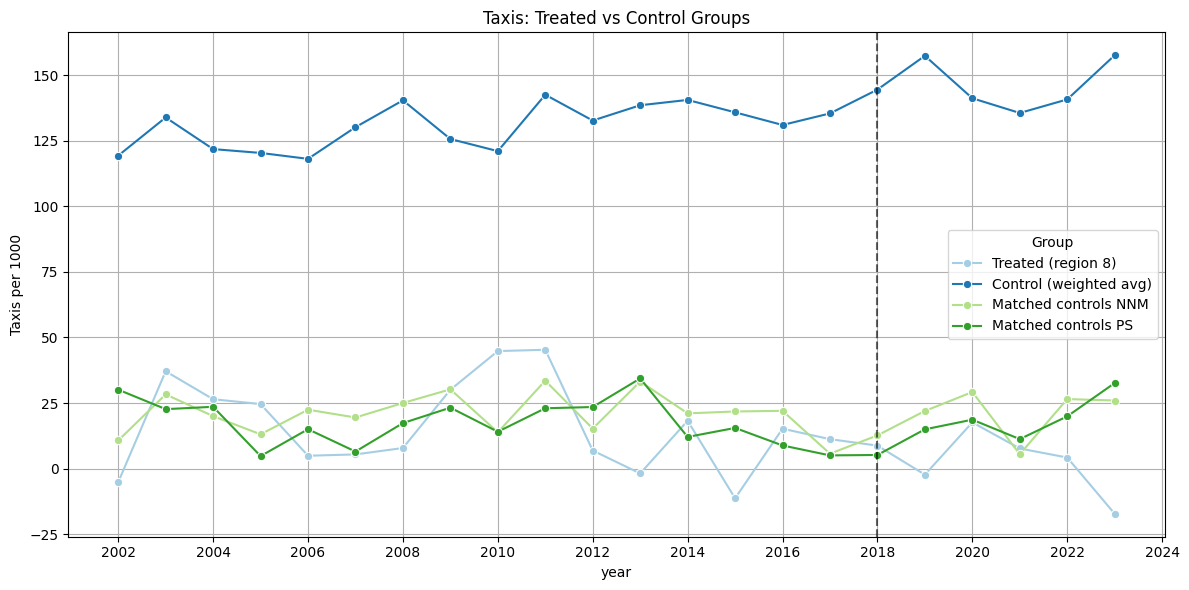

In [229]:
df['year'] = df['year'].astype(int)
df['population'] = df['population'].astype(float)

treated_group = df[df['region'] == '8'][['year', 'taxis_adj']].copy()
treated_group['group'] = 'Treated (region 8)'

control_group = (
    df[df['region'] != '8']
    .groupby('year')
    .apply(lambda x: np.average(x['taxis_adj'], weights=x['population']))
    .reset_index(name='taxis_adj')
)
control_group['group'] = 'Control (weighted avg)'

matched_group = (
    df[df['region'].isin(nnm_regions)]
    .groupby('year')
    .apply(lambda x: np.average(x['taxis_adj'], weights=x['population']))
    .reset_index(name='taxis_adj')
)
matched_group['group'] = 'Matched controls NNM'


matched_group2 = (
    df[df['region'].isin(matched_regions_ps)]
    .groupby('year')
    .apply(lambda x: np.average(x['taxis_adj'], weights=x['population']))
    .reset_index(name='taxis_adj')
)
matched_group2['group'] = 'Matched controls PS'

plot_df = pd.concat([treated_group, control_group, matched_group, matched_group2])

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x='year', y='taxis_adj', hue='group', marker='o')
plt.axvline(2018, color='black', linestyle='--', alpha=0.6)
plt.title('Taxis: Treated vs Control Groups')
plt.ylabel('Taxis per 1000')
plt.xticks(ticks=range(2002, 2026, 2))
plt.grid(True)
plt.tight_layout()
plt.legend(title='Group')
plt.show()

# DiD

Difference-in-Differences (aka DiD) is a popular method in causal inference used to estimate the effect of a treatment or intervention when randomized experiments are not feasible. The idea is to compare the change in outcomes over time between a treated group and a control group.

How it works:

1. Measure the outcome before and after the intervention for both groups.
2. Subtract the before–after difference in the control group from the before–after difference in the treated group.

The assumption is that, in the absence of treatment, both groups would have followed parallel trends.

Main assumptions and limitations:

- Parallel trends assumption
- No spillovers or interference
- No time-varying confounders
- Robustness (the method can be sensetive to specification errors and incorrect group matching)

The formula for regression was taken from [here](https://www.publichealth.columbia.edu/research/population-health-methods/difference-difference-estimation?utm_source=chatgpt.com)

In [262]:
df_subset = df[df['region'].isin(ps_regions_total)]
df_subset['post'] = df_subset['year'] >= 2018
df_subset['did'] = df_subset['post'] * df_subset['treatment']

model = smf.ols('taxis_adj ~ post+ treatment + did + users_with_cars + avg_disposable_income_in_pba',
                 data=df_subset).fit()
print(model.summary().tables[1])

                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -19.4164     10.698     -1.815      0.073     -40.693       1.861
post[T.True]                    -3.2973      3.995     -0.825      0.412     -11.244       4.649
treatment                       -7.4582      3.498     -2.132      0.036     -14.416      -0.501
did                             -7.4582      3.498     -2.132      0.036     -14.416      -0.501
users_with_cars                  0.0001      0.000      0.918      0.362      -0.000       0.000
avg_disposable_income_in_pba    19.1591      9.348      2.049      0.044       0.566      37.752


/var/folders/b5/c5pvdv8n0lx6dbv9jfk7n24r0000gn/T/ipykernel_885/1463585002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['post'] = df_subset['year'] >= 2018
/var/folders/b5/c5pvdv8n0lx6dbv9jfk7n24r0000gn/T/ipykernel_885/1463585002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['did'] = df_subset['post'] * df_subset['treatment']


The estimate of ATT (coefficient at did) = -7.5 -> that is, the introduction of scooters in region 8 led to a decrease in the number of taxis by 7.5 units relative to the trend of the control regions.

p-value = 0.036, the effect is statistically significant at the level of 5%.

# Synthetic Control Method 

Synthetic Control is very similar to linear regression. In fact, we do almost the same thing — we just rotate the data.

In linear regression, we have a lot of observations and few features. We teach the linear relationship between features and the target variable.

But in SC, the opposite is true: we have one treated unit, few checkpoints, and many time points. We teach you how to express the dynamics of a treated region through a combination of controls, but already in time.

For this to work, the data is sort of "transposed": now the times are strings, and the regions are features.

It looks like a regression, only with a different assumption:

- In regression, we assume that the relationship is the same for all observations.
- in SCM— that the connection is the same in time

In [254]:
def run_synthetic_control(df, regions, model_type='lasso', treated_region='8', outcome_var='taxis_adj',
                          pre_years=range(2002, 2017), post_years=range(2018, 2024)):
    
    df_filtered = df[df['region'].isin(regions)].copy()
    df_filtered = df_filtered[df_filtered['year'] >= min(pre_years)]
    df_filtered['year'] = df_filtered['year'].astype(int)
    df_filtered['region'] = df_filtered['region'].astype(str)

    df_pre = df_filtered[df_filtered['year'].isin(pre_years)]
    
    control_regions = [r for r in regions if r != treated_region]
    if not control_regions:
        raise ValueError("There are no control regions after exclusion treated_region.")
    
    Y = df_pre[df_pre['region'] == treated_region] \
        .sort_values('year') \
        .set_index('year')[outcome_var].values

    X = df_pre[df_pre['region'].isin(control_regions)] \
        .pivot(index='year', columns='region', values=outcome_var) \
        .sort_index(axis=1).values  

    if X.shape[0] == 0 or X.shape[1] == 0:
        raise ValueError("The X matrix is empty. Check the list of regions and the availability of data by year.")

    if model_type == 'lasso':
        model = Lasso(alpha=0.00001, fit_intercept=False, positive=True)
    elif model_type == 'ridge':
        model = Ridge(alpha=0.01, fit_intercept=False, positive=True)
    elif model_type == 'linear':
        model = LinearRegression(fit_intercept=False)

    model.fit(X, Y)
    weights = model.coef_

    df_post = df_filtered[df_filtered['region'].isin(control_regions)] \
        .pivot(index='year', columns='region', values=outcome_var) \
        .sort_index(axis=1).fillna(0)

    synthetic = df_post.values.dot(weights)

    treated_series = df_filtered[df_filtered['region'] == treated_region] \
        .sort_values('year')[outcome_var].values

    years = df_filtered['year'].sort_values().unique()

    plt.figure(figsize=(8, 3))
    plt.plot(years, treated_series, label='Treated (region 8)', linewidth=2)
    plt.plot(years, synthetic, label='Synthetic Control', linestyle='--', linewidth=2)
    plt.axvline(min(post_years), color='gray', linestyle='--')
    plt.title(f'Synthetic Control: Region {treated_region} vs Synthetic ({model_type})')
    plt.xlabel('Year')
    plt.xticks(ticks=range(min(years), max(years)+1, 2))
    plt.ylabel(outcome_var)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    years_pre = np.array([y for y in years if y in pre_years])
    treated_pre = treated_series[:len(years_pre)]
    synthetic_pre = synthetic[:len(years_pre)]

    mae = mean_absolute_error(treated_pre, synthetic_pre)
    rmse = np.sqrt(mean_squared_error(treated_pre, synthetic_pre))
    r2 = r2_score(treated_pre, synthetic_pre)

    print(f"Metrics - {model_type.capitalize()} Regression")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    weights_df = pd.DataFrame({
        'Region': control_regions,
        'Weight': weights
    })

   
    treated_post = treated_series[len(years_pre):]
    synthetic_post = synthetic[len(years_pre):]

    
    att_values = treated_post - synthetic_post
    ATT = att_values.mean()

    print(f"ATT: {ATT:.4f}")
    
    plt.figure(figsize=(8, 3))
    plt.plot(years[len(years_pre):], att_values, marker='o', label='ATT over time')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title('ATT (Treated - Synthetic) over Post-Treatment Period')
    plt.xlabel('Year')
    plt.ylabel('ATT')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    return weights_df, mae, rmse, r2, ATT


In [202]:
all_regions = df['region'].unique().tolist()
all_control_regions = [r for r in all_regions if r != '8']

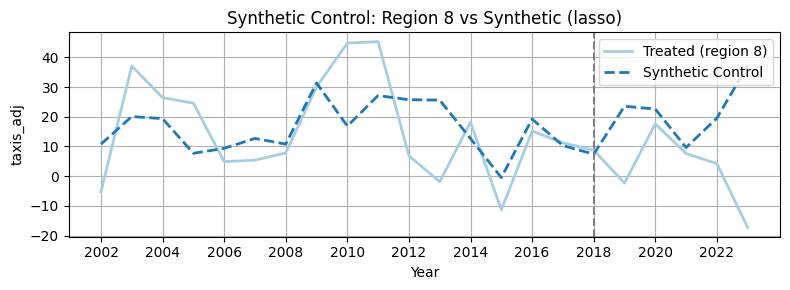

Metrics - Lasso Regression
MAE:  12.4012
RMSE: 14.9516
R²:   0.2413
ATT: -14.3543


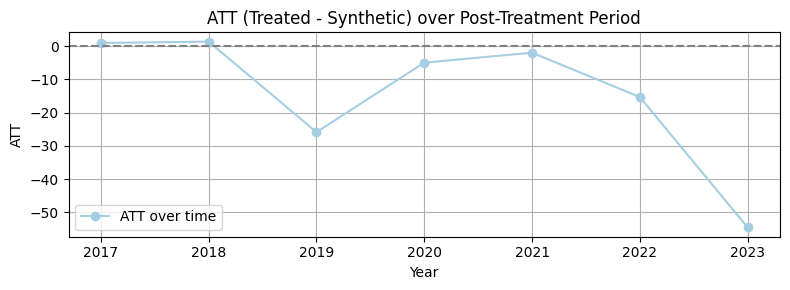

In [255]:
weights_df, mae, rmse, r2, att = run_synthetic_control(df, regions=ps_regions_total, model_type='lasso')


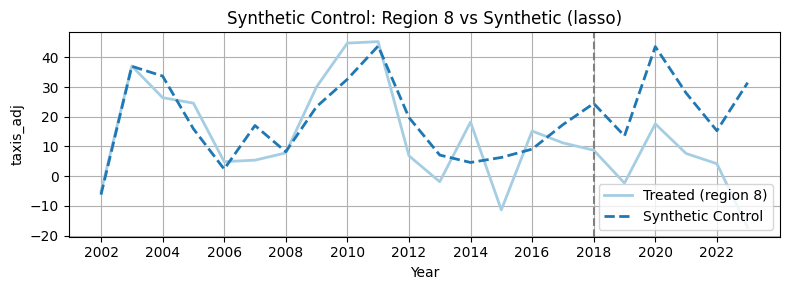

Metrics - Lasso Regression
MAE:  7.4103
RMSE: 9.1170
R²:   0.7179
ATT: -20.5724


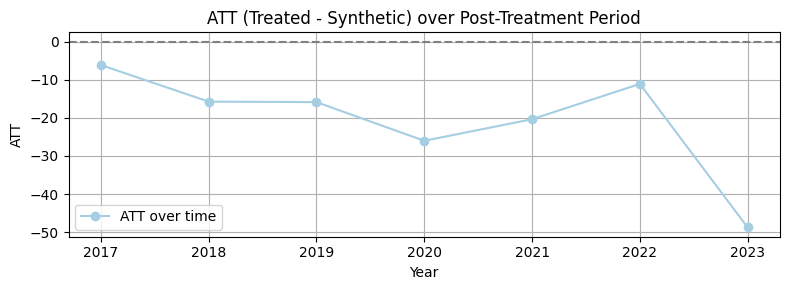

In [256]:
weights_df, mae, rmse, r2, att = run_synthetic_control(df, regions=all_regions, model_type='lasso')

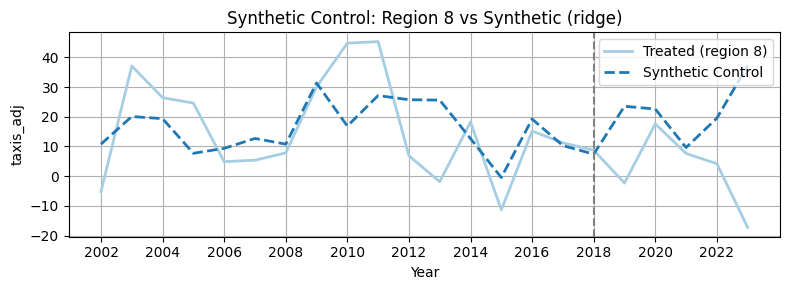

Metrics - Ridge Regression
MAE:  12.4012
RMSE: 14.9516
R²:   0.2413
ATT: -14.3542


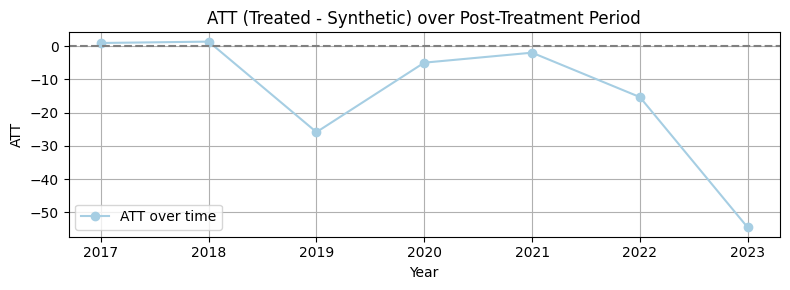

In [257]:
weights_df, mae, rmse, r2, att = run_synthetic_control(df, regions=ps_regions_total, model_type='ridge')

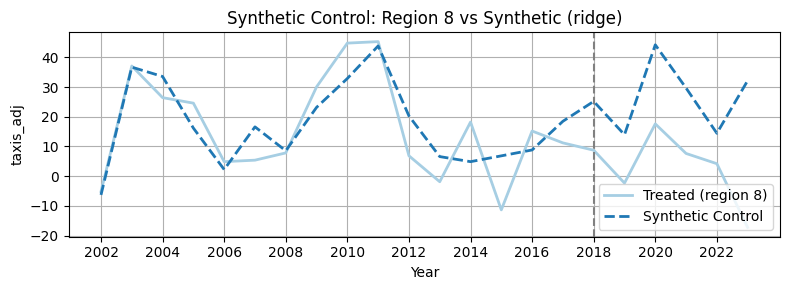

Metrics - Ridge Regression
MAE:  7.4452
RMSE: 9.1261
R²:   0.7173
ATT: -21.1939


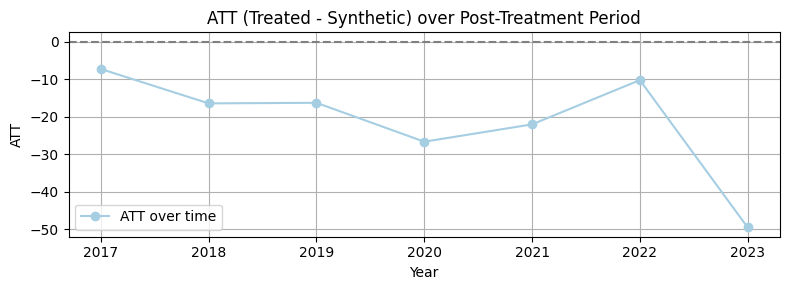

In [258]:
weights_df, mae, rmse, r2, att = run_synthetic_control(df, regions=all_regions, model_type='ridge')


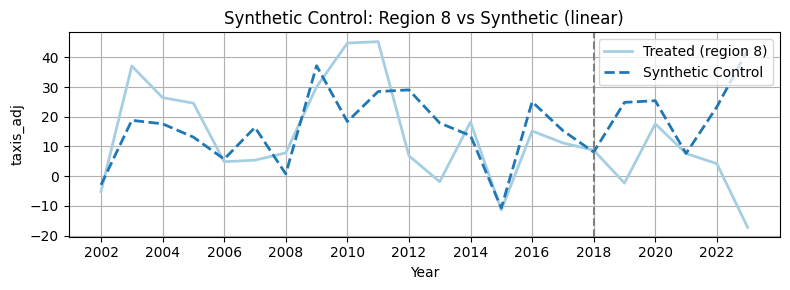

Metrics - Linear Regression
MAE:  11.1478
RMSE: 13.5517
R²:   0.3767
ATT: -16.7661


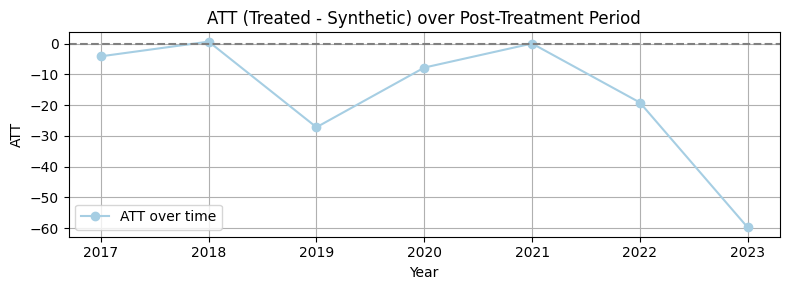

In [259]:
weights_df, mae, rmse, r2, att = run_synthetic_control(df, regions=ps_regions_total, model_type='linear')

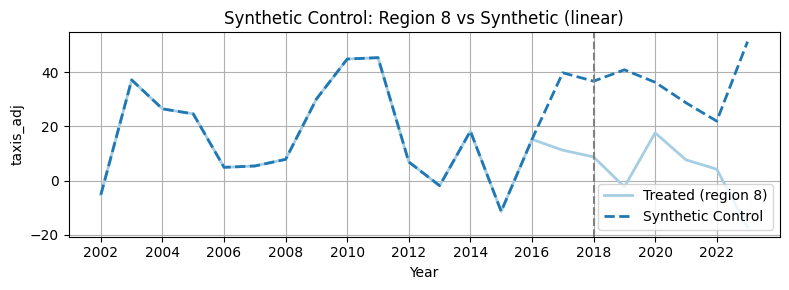

Metrics - Linear Regression
MAE:  0.0000
RMSE: 0.0000
R²:   1.0000
ATT: -32.2115


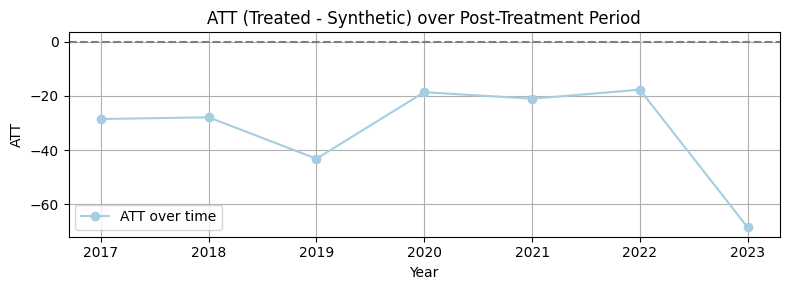

In [260]:
weights_df, mae, rmse, r2, att = run_synthetic_control(df, regions=all_regions, model_type='linear')

What is the conclusion: 
Lasso and ridge regressions do a poor job of sampling the selected Propensity Score regions. R2 is low, meaning there is not enough data to train the regression well. At the same time, the results are good in all regions, the models are penalized and are not allowed to retrain, which cannot be said about linear regression - an obvious overfitting.

We are satisfied with the metrics for this work, but in the future we can try to limit the sum of the weights of the coefficients to 1, based on this article [Understanding Synthetic Control Methods](https://towardsdatascience.com/understanding-synthetic-control-methods-dd9a291885a1).

Let's do a  **permutation test** to check how unusual our effect is. You need to do synthetic control for all donors, as if they were "treated", and compare the MSE ratio

In [271]:
def run_synthetic_lasso(y_treated, X_controls):
    model = LassoCV(cv=5).fit(X_controls, y_treated)
    weights = model.coef_
    synthetic = X_controls @ weights
    return synthetic, weights
# This is a metric that shows how much the prognosis has "worsened" after the intervention
def compute_lambda(y_real, y_synth, pre_mask, post_mask):
    mse_pre = mean_squared_error(y_real[pre_mask], y_synth[pre_mask])
    mse_post = mean_squared_error(y_real[post_mask], y_synth[post_mask])
    return mse_post / mse_pre if mse_pre > 0 else np.nan


intervention_year = 2018
years = df['year'].unique()
pre_mask = years < intervention_year
post_mask = years >= intervention_year


lambdas = {}
treated_lambda = None

regions = df['region'].unique()

for region in regions:

    y_region = df[df['region'] == region].sort_values('year')[outcome_var].values
    control_regions = [r for r in regions if r != region]
    X_region = df[df['region'].isin(control_regions)].pivot(index='year', columns='region', values=outcome_var).sort_index().fillna(0).values
    
    try:
        y_synth, _ = run_synthetic_lasso(y_region, X_region)
        lam = compute_lambda(y_region, y_synth, pre_mask, post_mask)
        lambdas[region] = lam
        if region == treated_region:
            treated_lambda = lam
    except:
        print(f"Error of region value {region}")
        continue

# permutated p-value
lambda_values = np.array([v for k, v in lambdas.items() if not np.isnan(v)])
p_value = np.mean(lambda_values >= treated_lambda)

print(f"Lambda (treated): {treated_lambda:.4f}")
print(f"P-value (permutation test): {p_value:.4f}")

Lambda (treated): 0.3795
P-value (permutation test): 1.0000


P-value: 1 — this means that all placebo regions had the same or even lower λ than region 8. In other words, nothing unusual happened in the treated region in terms of the gap between fact and synthetics. The effect is not statistically significant.

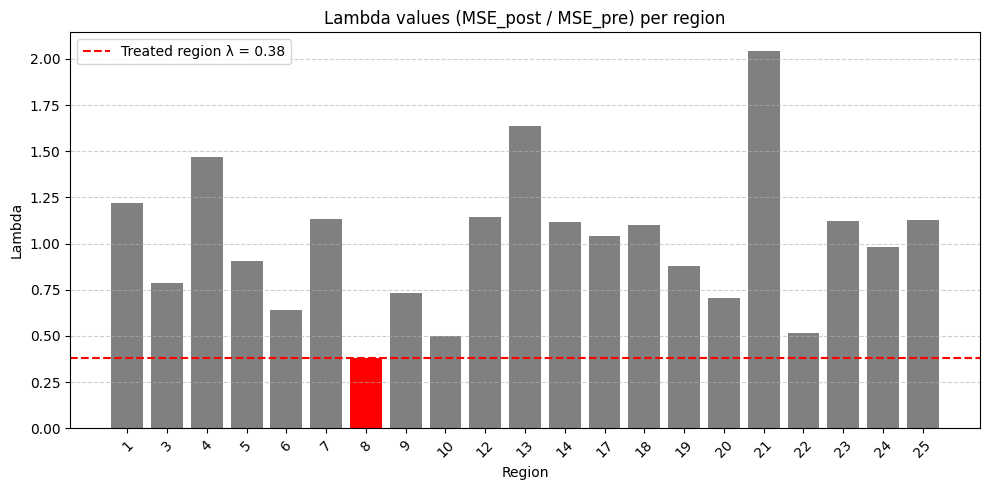

In [263]:
treated_lambda = lambdas[treated_region]

lambda_df = pd.DataFrame(list(lambdas.items()), columns=["Region", "Lambda"])
lambda_df["Region"] = lambda_df["Region"].astype(str)
lambda_df["Color"] = lambda_df["Region"].apply(lambda x: 'red' if x == treated_region else 'gray')


plt.figure(figsize=(10, 5))
bars = plt.bar(lambda_df["Region"], lambda_df["Lambda"], color=lambda_df["Color"])
plt.axhline(treated_lambda, color='red', linestyle='--', label=f"Treated region λ = {treated_lambda:.2f}")
plt.title("Lambda values (MSE_post / MSE_pre) per region")
plt.xlabel("Region")
plt.ylabel("Lambda")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

As can be seen from the metrics, the effect is small, add to this a large p-value. Although I manually lowered the indicator by 25%, the synthetic control model did not "feel" this as a unique effect, most likely due to the data structure, noise, or the quality of donor selection.

# Bayesian Structural Time Series (BSTS)


The idea of the method is to predict what would have happened without the intervention by constructing a counterfactual metric.

In [264]:
df_copy = df.copy()

df_copy['date'] = pd.to_datetime(df_copy['year'].astype(str) + '-01-01')
df_copy = df_copy[df_copy['date'] >= '2002-01-01'] 
df_copy = df_copy[df_copy['region']=='8']

df_copy['event_2017'] = (df_copy['year'] == 2017).astype(int)
df_copy['event_2022'] = (df_copy['year'] == 2022).astype(int)

df_copy['income_sq'] = df_copy['avg_disposable_income_in_pba'] ** 2
df_copy['tax_rate_sq'] = df_copy['tax_rate'] ** 2
df_copy['tax_x_income'] = df_copy['avg_disposable_income_in_pba'] * df['tax_rate']

train_df = df_copy[df_copy['year'] < 2018]
test_df = df_copy[df_copy['year'] >= 2018]


2025-08-06 14:30:00 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

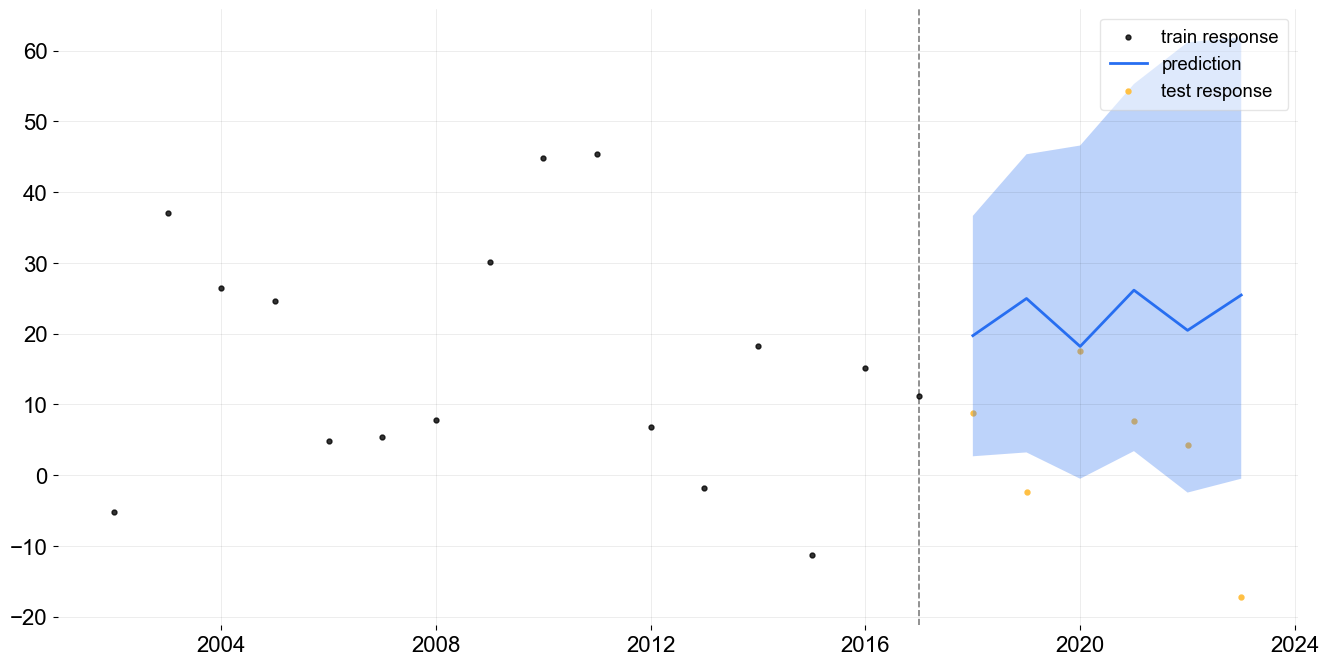

<Axes: >

In [275]:
dlt = DLT(
    response_col='taxis_adj',
    date_col='date',
    regressor_col=['users_with_cars', 'avg_disposable_income_in_pba', 'tax_rate','event_2017','income_sq','tax_rate_sq','tax_x_income', 'event_2022']
    )

dlt.fit(df=train_df)

predicted_df = dlt.predict(df=test_df, include_prediction_interval=True)

plot_predicted_data(
    training_actual_df=train_df,
    predicted_df=predicted_df,
    date_col='date',
    actual_col='taxis_adj',
    test_actual_df=test_df,
)


In [266]:
y_actual = test_df['taxis_adj'].values
y_pred = predicted_df['prediction'].values
delta = y_actual - y_pred

att_dlt = np.mean(delta)
ci_dlt = np.percentile(delta, [2.5, 97.5])

print(f"ATT: {att_dlt:.2f}")
print(f"95% CI: [{ci_dlt[0]:.2f}, {ci_dlt[1]:.2f}]")


ATT: -19.38
95% CI: [-40.78, -1.87]


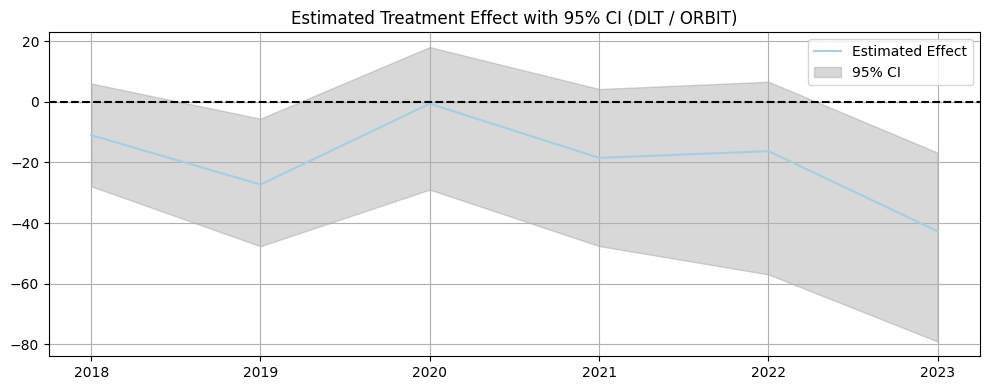

In [ ]:


predicted_df['effect'] = test_df['taxis_adj'].values - predicted_df['prediction'].values


predicted_df['lower_ci'] = test_df['taxis_adj'].values - predicted_df['prediction_95'].values
predicted_df['upper_ci'] = test_df['taxis_adj'].values - predicted_df['prediction_5'].values

plt.figure(figsize=(10, 4))
plt.plot(predicted_df['date'], predicted_df['effect'], label='Estimated Effect')
plt.fill_between(predicted_df['date'], predicted_df['lower_ci'], predicted_df['upper_ci'], color='gray', alpha=0.3, label='95% CI')
plt.axhline(0, linestyle='--', color='black')
plt.legend()
plt.title('Estimated Treatment Effect with 95% CI (DLT / ORBIT)')
plt.grid(True)
plt.tight_layout()
plt.show()

We see a generally stable negative effect in the BSTS model, and in most years it is significant in the 95% confidence interval. This confirms that the intervention did have an impact on the number of taxis.

BUT the BSTS model is terrible based on the data obtained before the intervention

In-sample metrics:
MAE:  13.1515
RMSE: 16.7946
R²:   -0.0149


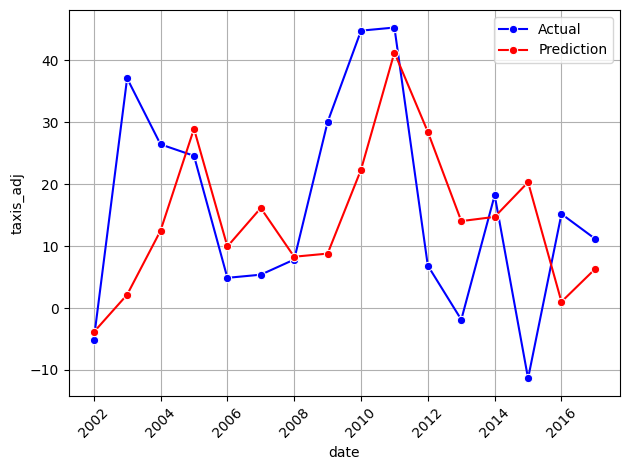

In [ ]:
in_sample_pred = dlt.predict(df=train_df)

y_true = train_df['taxis_adj'].values
y_pred = in_sample_pred['prediction'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"In-sample metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


sns.lineplot(data=train_df[['taxis_adj','date']], x="date", y="taxis_adj",  marker="o" ,  color="blue", label="Actual" )
sns.lineplot(data=in_sample_pred, x="date", y="prediction",  marker="o",  color="red", label="Prediction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

# To sum up

1. We applied two methods to balance the NNM and PSM covariates, which gave approximately the same results.

2. Using PSM-selected regions and modeling the treatment with an interaction term (DID), the estimated ATT was -7.46 taxis, with a p-value of 0.036.So DiD successfully detected a substantial share of the simulated -25% impact. 

    Strengths:

    - Intuitive and interpretable
    - Significant effect detected

    Limitations:

    - Strong reliance on the parallel trends assumption
    - May be biased in imbalanced settings (especially without PSM)

3. Synthetic Control Method. We applied several SCM variants: Lasso / Ridge / Linear regression weighting schemes. Using both all regions and PSM-matched subsets -> Best performance came from linear regression on all regions: R^2 = 0.71  and ATT ≈ -21 to -14, depending on the method. However, permutation tests showed: λ = 0.3795 with p-value = 1.0, what tells us even visually compelling, the synthetic control model failed to detect the effect as statistically unusual. The observed treatment gap could plausibly occur in other regions. One of the limitations is sensitive to noise and short pre-periods. Maybe that was our problem.

4. BSTS was implemented using the DLT model from Orbit (open-source Uber's library).  The post-treatment average effect was negative and stable, and the 95% confidence interval excluded zero in most years. However, in-sample fit was extremely poor -R2 = -0.01, indicating that the model couldn't explain even the training data well. Strengths of this model are providing probabilistic confidence intervals, but limitations that the model requires longer training periods and it's highly sensitive to noise and hyperparameter tuning. 

------ 
Despite a strong simulated treatment effect (-25%), only DiD provided both statistical significance and interpretability. SCM showed promising fits but failed robustness checks. BSTS hinted at significance but was fundamentally untrustworthy due to poor in-sample performance. When working with a real project, you need to focus on choosing covariates (as always) 
